# Background of detectree: tree detection from aerial imagery

This notebook presents an overview of how detectree implements the methods of Yang et al. [1] in order to detect tree pixels from aerial imagery.

In order to avoid issues with relative paths, let us first of all change the working directory to the repository's root

In [2]:
%cd ..

/home/martibosch/data-science/detectree-example


In [1]:
import glob
import os
import random
from os import path

import dask
import joblib as jl
import matplotlib.pyplot as plt
import rasterio as rio
from dask import diagnostics
from scipy import ndimage as ndi
from rasterio import plot

import detectree as dtr
from detectree import filters, image_descriptor, pixel_features 

figwidth, figheight = plt.rcParams['figure.figsize']
%matplotlib inline

Let us now use the Makefile at the root of this repository ensure that we have the required data input data - i.e., the tiles from [Zurich's RGB orthophoto of summer 2014/15](https://www.geolion.zh.ch/geodatensatz/2831) that lie within Zurich's municipal boundaries - has been downloaded.

In [3]:
!make tiles

make: Nothing to be done for 'tiles'.


Each tile consists of 21875x15000 pixels at a 10 cm resolution. For the "pedagogical" purposes of this repository, each tile will be rescaled to a resolution of 50 cm and subsequently split into 25 tiles, which will therefore be of 875x600 pixels.

In [4]:
%%bash
ls -l data/interim/tiles/*.tif | head

-rw-rw-r-- 1 martibosch martibosch  88872 Sep 26 15:28 data/interim/tiles/1091-124_00.tif
-rw-rw-r-- 1 martibosch martibosch  89831 Sep 26 15:28 data/interim/tiles/1091-124_01.tif
-rw-rw-r-- 1 martibosch martibosch  97908 Sep 26 15:28 data/interim/tiles/1091-124_02.tif
-rw-rw-r-- 1 martibosch martibosch 126171 Sep 26 15:28 data/interim/tiles/1091-124_03.tif
-rw-rw-r-- 1 martibosch martibosch 135263 Sep 26 15:28 data/interim/tiles/1091-124_04.tif
-rw-rw-r-- 1 martibosch martibosch  93705 Sep 26 15:28 data/interim/tiles/1091-124_05.tif
-rw-rw-r-- 1 martibosch martibosch  93087 Sep 26 15:28 data/interim/tiles/1091-124_06.tif
-rw-rw-r-- 1 martibosch martibosch 100202 Sep 26 15:28 data/interim/tiles/1091-124_07.tif
-rw-rw-r-- 1 martibosch martibosch 111449 Sep 26 15:28 data/interim/tiles/1091-124_08.tif
-rw-rw-r-- 1 martibosch martibosch 140590 Sep 26 15:28 data/interim/tiles/1091-124_09.tif


This is what a tile looks like:

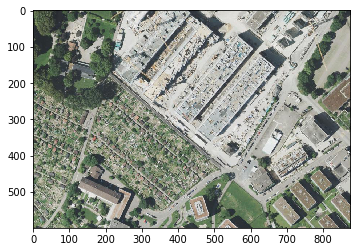

In [5]:
img_filepath = random.choice(glob.glob('data/interim/tiles/*.tif'))

with rio.open(img_filepath) as src:
    plot.show(src.read())

Since 9 raw tiles have been downloaded (check the logs above), and each tile has been split into 25 tiles, there should be a total of 225 tiles:

In [6]:
%%bash
ls data/interim/tiles/*.tif | wc -w

225


## Pixel features

The key task of this library is to perform a binary pixel-level classification of tree/non-tree pixels. This is done by means of the `PixelFeatureBuilder` class:

In [7]:
pfb = pixel_features.PixelFeaturesBuilder()

The initialization method of `PixelFeatureBuilder` accepts five keyword arguments that customize how the features are built.

With the default argument values, which follow the methods of Yang et al. [1], each pixel is transformed into a 27-feature vector where 6, 18 and 3 features capture characteristics of color, texture and entropy respectively.

Given the path to a RGB image, its pixel feature matrix can be built as in:

In [8]:
X = pfb.build_features_from_filepath(img_filepath)

which will return a matrix where each row represents a pixel and each column represents its features.

In [9]:
X.shape

(525000, 27)

The task of classifying tree/non-tree pixels becomes a supervised learning problem, where given the tree/non-tree labels of a subset of pixels (i.e., the *training samples*), a classifier mapping the pixel features to the tree/non-tree responses would be trained and later used to classify the values for the remaining pixels.


## Train/test split

In order to enhance the robustness of the classifier, it is important that the subset of pixels selected as *training samples* are representative of the whole dataset.

Consider the 225-tile dataset that is stored at the `data/interim/tiles` directory (see above). A straight-forward approach to the selection of the *training samples* would be to randomly select a subset of tiles (e.g., 1%) as *training samples*. Nevertheless, given the large variety of scenes that can be found in such a datset of urban aerial imagery (e.g., lakes, buildings, parks, forests...), a random selection of training tiles might not be representative of such variety and therefore lead to a classifier with low overall accuracy.

To overcome such problem, Yang et al. [1] proposed a procedure of selecting *training samples* that intends to find the set of tiles that is most representative of the dataset.


### Image descriptor

The scene structure of an image can be represented by a Gist descriptor [2], a low dimensional vector encoding which captures the high-level semantics of real-world aerial images. 

Following the approach of Yange et al. [1], the image descriptor is computed by: 

* convolving it with Gabor filters on 3 frequencies and 4, 8 and orientations respectively, which accounts for 320 components
* computing a 8x8x8 joint color histogram in the L*a*b color space, which accounts for 512 components

the two components are normalized to unit L-1 norm separatedly and then concatenated to form a 832-component image descriptor.

With detectree, such image descriptor can be computed by means of the `compute_image_descriptor_from_filepath` function as in:

In [10]:
kernels = filters.get_gabor_filter_bank(frequencies=(.1, .25, .4),
                                        num_orientations=(4, 8, 8))
response_bins_per_axis = 4
num_color_bins = 8

img_descr = image_descriptor.compute_image_descriptor_from_filepath(
    img_filepath,
    kernels=kernels,
    response_bins_per_axis=response_bins_per_axis,
    num_color_bins=num_color_bins)

which will return a vector that represents the image descriptor:

In [11]:
img_descr.shape

(832,)

### Selection of the training tiles

Two methods to select the training tiles are proposed by Yang et al. [1]:

* 'Cluster-I': applying *k*-means clustering to the image descriptors in order to obtain k clusters, where *k* corresponds to 1% of the total number of tiles, and selecting the cluster centroids as training tiles
* 'Cluster-II': first apply *k*-means clustering to the image descriptors to divide the dataset into four first-level clusters. Within each cluster, use the method of 'Cluster-I' to select a 1% s training tiles and train **a separate classifier** for each first-level cluster

In order to reduce the computational cost of the *k*-means clustering, Principal Component Analysis (PCA) might be used in order to reduce the dimensionality of the image descriptors, e.g., to 12 components.

The class `TrainingSelector` of detectree implements the two methods described above. It can be instantiated as:

In [12]:
img_dir = 'data/interim/tiles'

ts = dtr.TrainingSelector(img_dir=img_dir)

where `img_dir` is the relative path to the directory where the images/tiles are stored. Note that the initialization method of `TrainingSelector` accepts further keyword arguments to customize how the image descriptors are computed (see [its documentation](https://detectree.readthedocs.io/en/latest/train_test_split.html#detectree.TrainingSelector.__init__) for more details), which are forwarded to the `compute_image_descriptor_from_filepath` method. The default values will compute the 832-component image descriptor described above.

After the instantiation of a `TrainingSelector`, its `train_test_split` method can be used as follows (the processing can take a while since it involves the computation of the image descriptor for each tile):

In [13]:
split_df, evr = ts.train_test_split(method='cluster-II',
                                    num_components=12,
                                    return_evr=True)

[########################################] | 100% Completed |  3min 10.4s


The `method` argument can be either `'cluster-II'` or `'cluster-I'` (it defaults to the former), while `num_components` refers to the number of PCA components. 
The `train_test_split` method returns a pandas data frame with the train test split. Additionally, if `return_evr` is `True`, `train_test_split` also returns the variance ratio explained by the PCA.

In [14]:
evr

0.8178523091933059

In this example, the 12 components of the PCA account for an 81.79% of the variance found in the 832-component image descriptors. Since the computation of the image descriptors for all the tiles of the dataset can be computationally expensive, it will be cached as a Python property so that further accesses run in constant time:

In [15]:
ts.descr_feature_matrix

array([[0.00219413, 0.0022846 , 0.00186735, ..., 0.        , 0.        ,
        0.        ],
       [0.00238807, 0.00225381, 0.00198718, ..., 0.        , 0.        ,
        0.        ],
       [0.00218202, 0.00223396, 0.00215154, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00188557, 0.00218369, 0.00179943, ..., 0.        , 0.        ,
        0.        ],
       [0.00174613, 0.00240853, 0.00223016, ..., 0.        , 0.        ,
        0.        ],
       [0.00199617, 0.0018531 , 0.0023658 , ..., 0.        , 0.        ,
        0.        ]])

Note that such a matrix consists of 225 rows featuring each tiles' full image descriptor (832-components):

In [16]:
ts.descr_feature_matrix.shape

(225, 832)

The explained variance ratio can be incresed by setting a higher number of components in the PCA, as in:

In [17]:
split_df, evr = ts.train_test_split(method='cluster-II',
                                    num_components=24,
                                    return_evr=True)

Note that given the cache mechanism of the `descr_feature_matrix` property, this subsequent call to `train_test_split` runs much faster. In any case, the explained variance ratio with 24 components of the PCA is the following:

In [18]:
evr

0.9288584756690044

Let us analize now the pandas data frame that features the computed train/test split:

In [19]:
split_df.head()

,img_filepath,img_cluster,train
0,data/interim/tiles/1091-322_00.tif,0,False
1,data/interim/tiles/1091-142_20.tif,0,False
2,data/interim/tiles/1091-124_11.tif,2,False
3,data/interim/tiles/1091-144_21.tif,1,False
4,data/interim/tiles/1091-213_05.tif,2,True


The `img_cluster` column represents the label of the first-level cluster described for the method `cluster-II`. Note that had `method='cluster-I'` been passed to `train_test_split`, the resulting data frame would not feature such a column.

In this example, we have:

In [20]:
for img_cluster, img_cluster_df in split_df.groupby('img_cluster'):
    print(img_cluster, len(img_cluster_df),
          len(img_cluster_df[img_cluster_df['train']]))

0 92 1
1 34 1
2 16 1
3 83 1


The 4 first-level clusters feature 92, 35, 83 and 15 tiles respectively (recall that such clusters have been obtained according to the scene similarity of the tiles as represented by its image descriptor). For each first-level cluster, the *n* tiles that are closest to the cluster's centroid have been selected for training until 1% of the cluster's tiles. Note that in this example, given the limited number of tiles, only *n=1* tiles have been selected for training in each cluster.


### Preparing the responses

Since the approach described in this notebook is a supervised learning task, it requires providing the response data, namely the tree/non-tree pixel labels of the tiles selected as *training samples*. In this example, such *training samples* correspond to the following tiles:

In [21]:
split_df[split_df['train']]

,img_filepath,img_cluster,train
4,data/interim/tiles/1091-213_05.tif,2,True
28,data/interim/tiles/1091-231_12.tif,0,True
98,data/interim/tiles/1091-144_06.tif,1,True
172,data/interim/tiles/1091-231_07.tif,3,True


Therefore, in order to perform the tree/non-tree pixel classification for this dataset, for each of the tiles listed above, a binary image representing the ground-truth tree/non-tree masks must be provided.

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343).

To that end, the Makefile at the root directory of this repository features a `response_tiles` target, which will automatically download the required LIDAR data and generate the response masks for the tiles selected as training. Before such target can be executed, the train/test split data frame must be dumped to the following file (see the code of the Makefile for more details):

In [22]:
split_df.to_csv('data/interim/tiles/split.csv')

Now the target can be executed:

In [23]:
!make response_tiles

python src/make_response_tiles.py data/interim/tiles/split.csv data/raw/lidar/lidar2014.shp \
	data/interim/response_tiles data/interim/response_tiles/response_tiles.csv
2019-11-14 11:42:32,102 - __main__ - INFO - Dumped response tile to data/interim/response_tiles/1091-213_05.tif
2019-11-14 11:43:53,162 - __main__ - INFO - Dumped response tile to data/interim/response_tiles/1091-231_12.tif
2019-11-14 11:44:33,672 - __main__ - INFO - Dumped response tile to data/interim/response_tiles/1091-144_06.tif
2019-11-14 11:45:42,154 - __main__ - INFO - Dumped response tile to data/interim/response_tiles/1091-231_07.tif
2019-11-14 11:45:45,261 - __main__ - INFO - Dumped list of response tiles to data/interim/response_tiles/response_tiles.csv


For each tile selected as training in `data/interim/tiles/split.csv`, the above Makefile target will dump the respective LIDAR-generated ground-truth mask to the directory `data/interim/response_tiles` (with the same file name).

In [24]:
!ls -l data/interim/response_tiles/*.tif

-rw-rw-r-- 1 martibosch martibosch 525946 Nov 14 11:44 data/interim/response_tiles/1091-144_06.tif
-rw-rw-r-- 1 martibosch martibosch 525946 Nov 14 11:42 data/interim/response_tiles/1091-213_05.tif
-rw-rw-r-- 1 martibosch martibosch 525946 Nov 14 11:45 data/interim/response_tiles/1091-231_07.tif
-rw-rw-r-- 1 martibosch martibosch 525946 Nov 14 11:43 data/interim/response_tiles/1091-231_12.tif
-rw-rw-r-- 1 martibosch martibosch 525946 Nov 12 11:03 data/interim/response_tiles/1091-322_11.tif


Below is an example plot of a tile and its LIDAR-generated ground-truth mask:

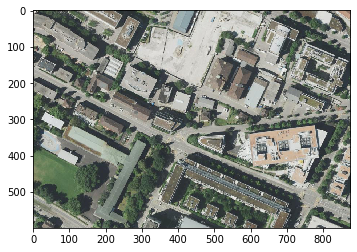

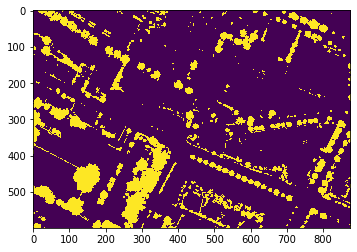

In [25]:
response_dir = 'data/interim/response_tiles'

img_filepath = split_df[split_df['train']]['img_filepath'].sample(1).iloc[0]
response_filepath = path.join(response_dir, path.basename(img_filepath))

for filepath in [img_filepath, response_filepath]:
    with rio.open(filepath) as src:
        plot.show(src.read())

### Training the classifiers

Considering the train/test split of this example, following the Cluster-II method of Yang et al. [1], four AdaBoost classifiers must be trained, namely one for each first-level tile cluster. See the [baseline]() and [cluster-I]() notebooks for different approaches also using detectree. Training an AdaBoost ensemble is a computationally expensive task that can hardly be parallelized, nevertheless, the training of the four independent classifiers is an embarrassingly-parallel task, which is executed in parallel (by means of dask) in the `train_classifiers` method of the `ClassifierTrainer` class.

In [26]:
ct = dtr.ClassifierTrainer()
clf_dict = ct.train_classifiers(split_df, response_dir)

[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  9min 34.9s


On the other hand, once trained, each classifier can be persisted (e.g., to the `models` directory) by means of joblib ([as suggested in the documentation of scikit-learn](https://scikit-learn.org/stable/modules/model_persistence.html)).

In [27]:
models_dir = 'models'

if not path.exists(models_dir):
    os.mkdir(models_dir)

for img_cluster in clf_dict:
    jl.dump(clf_dict[img_cluster],
            path.join(models_dir, f'{img_cluster}.joblib'))

### Classifying tiles

Once the classifiers have been trained, classifying the tree/non-tree pixels of an image is straight-forward, and can be done in detectree by means of the `classify_img` method of the `Classifier` class. As noted by Yang et al. [1], when it comes to detecting trees in raster images, a key disadvantage of pixel-level classification is that each pixel is predicted independently, disregarding the consistence between adjacent pixels that configure trees. To overcome such shortcoming, Yang et al. [1] suggest a refinement of the pixel-level classification which consists in optimizing the consistence between neighboring pixels by means of the graph cuts algorithm of Boykov and Kolmogorov [3]. Such classification refinement is implemented in detectree by means of the [maxflow](https://pmneila.github.io/PyMaxflow/maxflow.html) package.

In [28]:
# load a non-training tile
img_row = split_df[~split_df['train']].iloc[0]
img_filepath = img_row['img_filepath']
img_cluster = img_row['img_cluster']

# get the classifier of the tile's corresponding first-level cluster
clf = clf_dict[img_cluster]

# classify the tile
y_nonrefined = dtr.Classifier(refine=False).classify_img(img_filepath, clf)
# `refine=True` by default in `Classifier`
c = dtr.Classifier()
y = c.classify_img(img_filepath, clf)

Let us compare the classification results without and with the refinement procedure respectively:

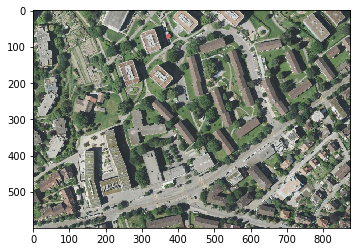

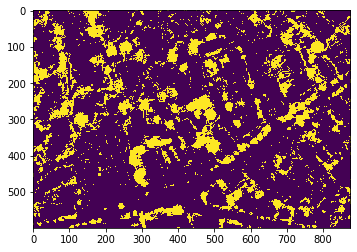

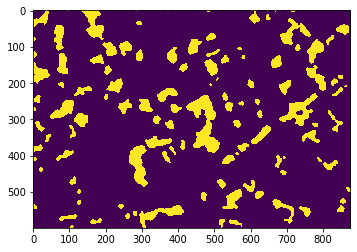

In [29]:
with rio.open(img_filepath) as src:
    plot.show(src.read())

plt.imshow(y_nonrefined)
plt.figure()
plt.imshow(y)

It is clear that the refinement procedure erodes false isolated tree pixels and also fills small holes in tree crowns. Note that the refinement procedure can be parametrized by means of the `refine_beta` and `refine_scale` arguments of the `classify_img` method (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.classify_img) for more details).

If multiple tiles are to be classified, it might be more appropriate to use the `classify_imgs` method, which operates directly on the train/test split data frame and the dictionary of classifiers `clf_dict` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.classify_imgs) for more details), and uses dask to classify the tiles in parallel. Additionally, if the keyword argument `output_dir` is provided, the predicted tree/non-tree images will be further dumped to such directory.

In [30]:
output_dir = 'data/interim/background_pred-tiles'
if not path.exists(output_dir):
    os.mkdir(output_dir)

sample_df = split_df[~split_df['train']].sample(20)
pred_tiles = c.classify_imgs(sample_df, output_dir, clf_dict=clf_dict)

[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 24.5s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 26.8s


By default, the dumped image files use a value of 255 to denote tree pixels and a value of 0 (which is also the nodata value) for the non-tree pixels. However this can be customized by passing the `tree_val` and `nodata_val` keyword arguments to the initialization of `Classifier` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.__init__) for more details).

Let us conclude with a sample of side-to-side plots of original tiles and their predicted tree/non-tree labels (one tile per first-level cluster):

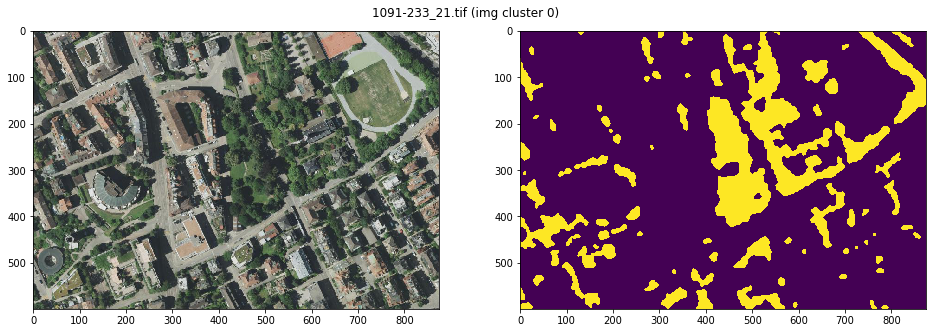

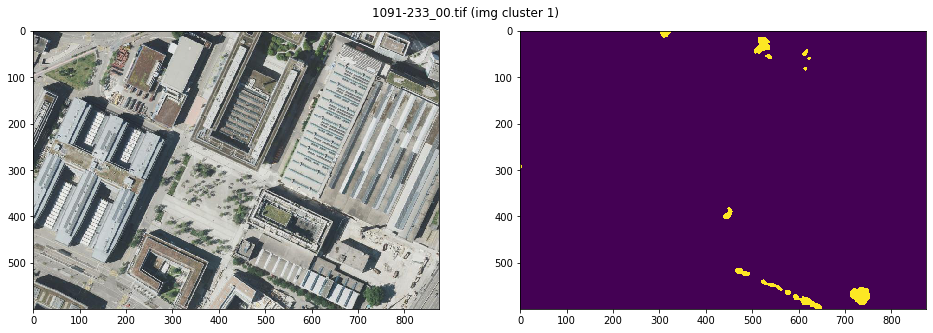

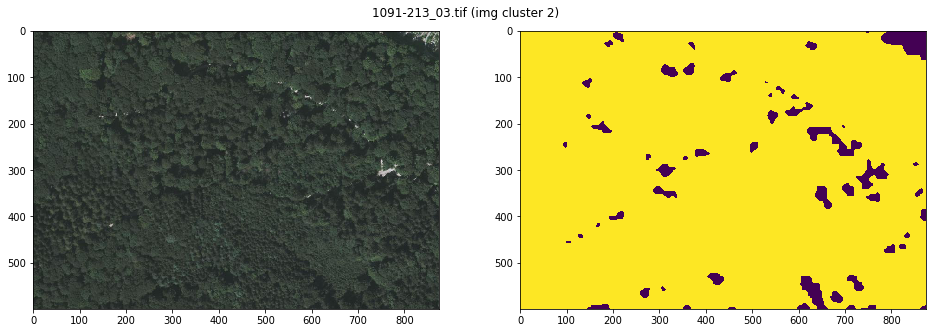

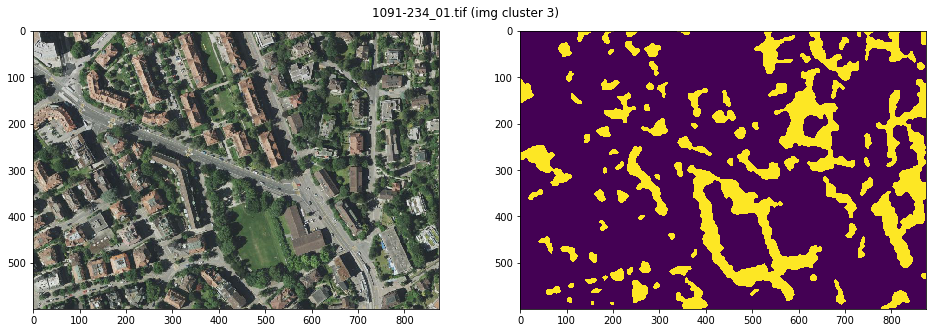

In [31]:
for img_cluster in pred_tiles:
    pred_filepath = random.choice(pred_tiles[img_cluster])
    img_basename = path.basename(pred_filepath)
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    fig.suptitle(f'{img_basename} (img cluster {img_cluster})', y=.88)

    img_filepath = path.join(img_dir, img_basename)
    for filepath, ax in zip((img_filepath, pred_filepath), axes):
        with rio.open(filepath) as src:
            plot.show(src.read(), ax=ax)

## References

1. Yang, L., Wu, X., Praun, E., & Ma, X. (2009). Tree detection from aerial imagery. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 131-137). ACM.

2. Oliva, A., & Torralba, A. (2001). Modeling the shape of the scene: A holistic representation of the spatial envelope. International journal of computer vision, 42(3), 145-175.

3. Boykov, Y., & Kolmogorov, V. (2004). An experimental comparison of min-cut/max-flow algorithms for energy minimization in vision. IEEE Transactions on Pattern Analysis & Machine Intelligence, (9), 1124-1137.